In [5]:
import h5py
import merlintf

# Load sample data
# Image sizes (batch, coils, frames, M, N)
# k-space (1, 34, 25, 192, 156)
# mask (1, 1, 25, 1, 156)
# smaps (1, 34, 1, 192, 156)

with h5py.File('cine2dt.h5', 'r') as ds:
    kspace = ds['kspace'][()]
    mask = ds['mask'][()]
    smaps = ds['smaps'][()]

# reconstruction operators
A = merlintf.keras.layers.MulticoilForwardOp(center=True, coil_axis=-4, channel_dim_defined=False)
AH = merlintf.keras.layers.MulticoilAdjointOp(center=True, coil_axis=-4, channel_dim_defined=False)

# apply adjoint
img_us = AH(kspace, mask, smaps)

# iterative sense
optim = merlintf.keras.layers.itSENSE(A, AH, weight=0, max_iter=10)
img_itSENSE = optim([kspace, mask, smaps]).numpy()
img_tf = img_itSENSE

In [7]:
import h5py
import merlinth
import torch

# Load sample data
# Image sizes (batch, coils, frames, M, N)
# k-space (1, 34, 25, 192, 156)
# mask (1, 1, 25, 1, 156)
# smaps (1, 34, 1, 192, 156)

with h5py.File('cine2dt.h5', 'r') as ds:
    kspace = torch.from_numpy(ds['kspace'][()])
    mask = torch.from_numpy(ds['mask'][()])
    smaps = torch.from_numpy(ds['smaps'][()])

# reconstruction operators
A = merlinth.layers.MulticoilForwardOp(center=True, coil_axis=-4, channel_dim_defined=False)
AH = merlinth.layers.MulticoilAdjointOp(center=True, coil_axis=-4, channel_dim_defined=False)

# apply adjoint
img_us = AH(kspace, mask, smaps)

# iterative sense
optim = merlinth.layers.itSENSE(A, AH, weight=0, max_iter=10)
img_itSENSE = optim([kspace, mask, smaps]).numpy()
img_th = img_itSENSE

Text(0.5, 1.0, 'Iterative SENSE')

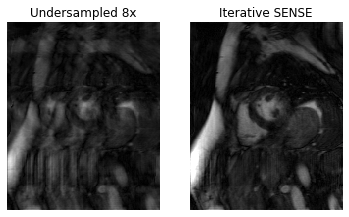

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.subplot(1,2,1)
plt.imshow(np.abs(img_us[0,5]), cmap='gray', vmax=0.00005)
plt.axis('off')
plt.title('Undersampled 8x')
plt.subplot(1,2,2)
plt.imshow(np.abs(img_itSENSE[0,5]), cmap='gray', vmax=0.0001)
plt.axis('off')
plt.title('Iterative SENSE')

Text(0.5, 1.0, 'Iterative SENSE')

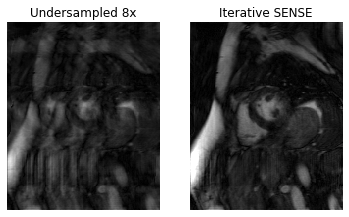

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.subplot(1,2,1)
plt.imshow(np.abs(img_us[0,5]), cmap='gray', vmax=0.00005)
plt.axis('off')
plt.title('Undersampled 8x')
plt.subplot(1,2,2)
plt.imshow(np.abs(img_itSENSE[0,5]), cmap='gray', vmax=0.0001)
plt.axis('off')
plt.title('Iterative SENSE')